# Importing Module and define directories

In [1]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,Normalize

In [2]:

def plot_results(network):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
    netw.predict(input_data)


# Train - Validation Split

In [3]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
#raw_data=np.delete(raw_data,10,axis=1)
np.random.shuffle(raw_data)
#raw_normalizer=Normalize()
#raw_data=raw_normalizer.normalize(raw_data)

In [4]:

frac_test=0.15
data, test_set=split(raw_data,kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
training,validation=split(data,kind="hold_out",frac_training=frac_training)

input_data=training[:,1:-2]
labels=training[:,-2:]
val_data=validation[:,1:-2]
val_labels=validation[:,-2:]

In [5]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Define the MLP

In [17]:
structure=[40,np.shape(labels)[1]]
act_func=[("sigmoid",1),("linear",1)]
start=xavier(structure)

netw = MLP(structure, func=act_func,
           starting_points=start)

In [7]:
start

[0.38729833462074165, 0.3779644730092272]

## Train the model

In [8]:
rho = 0.01
eta_0 = 6e-5
eta_stop = 0.0001
delta=1e-7
kind="eta_decay"
def eta_function(eta_start, eta_decay, # Mandatory parameters
                 train_MEE=None, val_MEE=None, epoch=None): # Parameters of the training (and of the MLP)
    return eta_start * np.exp(-eta_decay * epoch)
eta_params = [eta_0, rho, 'train_MEE', 'val_MEE', 'epoch'] # Pass in list like that:
# First the mandatory parameters and then the attribute of the class to extract
eta_function=1e-2

In [22]:
N_epoch = 500
lamb=0
batch_size = 50 #-1 for batch gradient descent
alpha=0.1
nesterov=False
eta_function=1e-4
beta=0.2
netw.train(input_data, labels, val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta =eta_function, eta_params = eta_params, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta)

KeyboardInterrupt: 

# Plot results

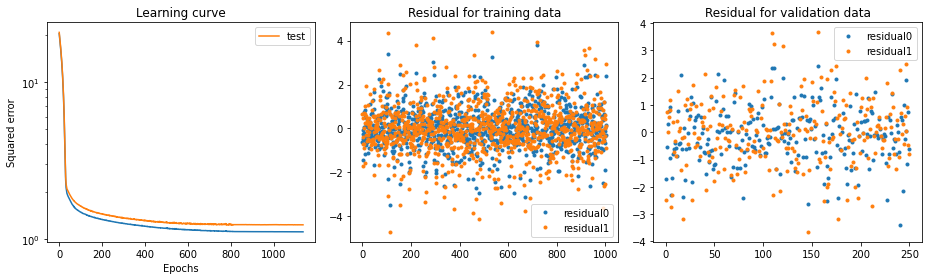

In [23]:

plot_results(netw)

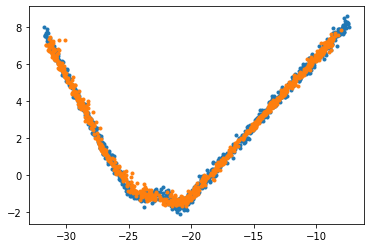

In [26]:
pred=netw.predict(input_data)
plt.plot(labels[:,1],labels[:,0],".")
plt.plot(pred[:,1],pred[:,0],".")

In [29]:
#numpy correlation matrix for input_data features
corr_matrix=np.corrcoef(raw_data,rowvar=False)

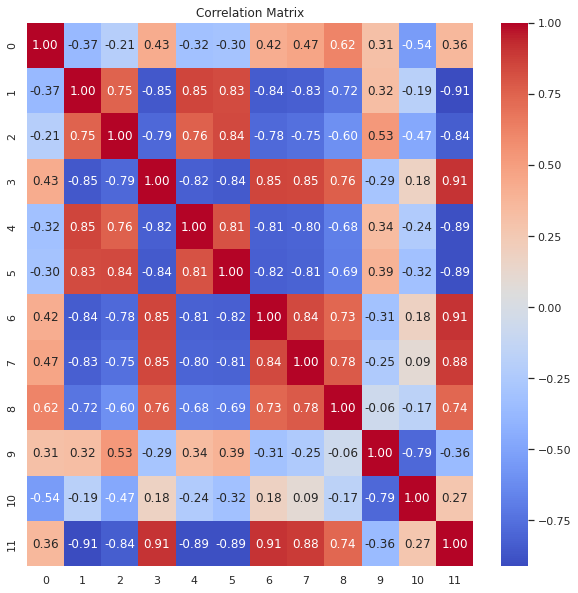

In [30]:
import seaborn as sns
#matplotlib heat map matrix for input_data features
plt.figure(figsize=(10,10))
plt.title("Correlation Matrix")
sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap="coolwarm")
plt.show()


In [30]:
from keras.layers import Input, Dense
from keras.models import Model
inp=Input(shape=(9,))
hidden=Dense(40,activation='sigmoid')(inp)
output=Dense(2,activation='linear')(hidden)

model=Model(inputs=inp,outputs=output)
model.compile(optimizer='adam',loss='mse')
model.fit(input_data,labels,epochs=1000,verbose=1)

Epoch 1/1000
32/32 [==============================] - 0s 4ms/step - loss: 222.1003
Epoch 2/1000
32/32 [==============================] - 0s 4ms/step - loss: 204.2513
Epoch 3/1000
32/32 [==============================] - 0s 3ms/step - loss: 187.6360
Epoch 4/1000
32/32 [==============================] - 0s 3ms/step - loss: 172.0900
Epoch 5/1000
32/32 [==============================] - 0s 3ms/step - loss: 157.7301
Epoch 6/1000
32/32 [==============================] - 0s 4ms/step - loss: 144.1149
Epoch 7/1000
32/32 [==============================] - 0s 4ms/step - loss: 131.2701
Epoch 8/1000
32/32 [==============================] - 0s 3ms/step - loss: 119.0856
Epoch 9/1000
32/32 [==============================] - 0s 5ms/step - loss: 107.5117
Epoch 10/1000
32/32 [==============================] - 0s 5ms/step - loss: 96.7015
Epoch 11/1000
32/32 [==============================] - 0s 4ms/step - loss: 86.6464
Epoch 12/1000
32/32 [==============================] - 0s 3ms/step - loss: 77.3482
Epoc

In [37]:
model.fit(input_data,labels,epochs=1000,verbose=1)

Epoch 1/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.7852
Epoch 2/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7824
Epoch 3/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7810
Epoch 4/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7834
Epoch 5/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7815
Epoch 6/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7828
Epoch 7/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7832
Epoch 8/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7787
Epoch 9/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7822
Epoch 10/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7812
Epoch 11/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7791
Epoch 12/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.7798
Epoch 13/1000
32/32 [====

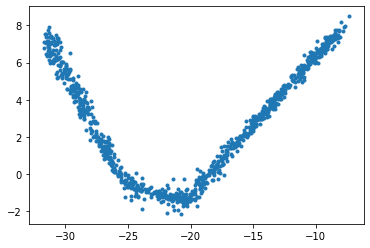

In [38]:
pred=model.predict(val_data)
tr=model.predict(input_data)
#plt.plot(labels[:,1],labels[:,0],".")
plt.plot(tr[:,1],tr[:,0],".")
#plt.plot(pred[:,1],pred[:,0],".")